1. Calculer les 6 points à l'infini
   1. Trouver intersections avec `findChessboardCorner` de openCV -> trouver les points intérieurs
   2. Raffiner avec `refineCorner` pour être sous pixelique
   3. Calculer droite de régression pour chaque ligne
   4. Point à l'infini : centroide des intersections de lignes 
2. Redresser l'image
3. Calibration de la matrice caméra : page 224

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import cv2 as cv
from copy import deepcopy

from scipy.stats import linregress
from scipy.linalg import svd
from itertools import combinations
import scipy


In [8]:
# Reading image

fname = "data/view1.jpg"
img = cv.imread(fname)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

IMG_HEIGHT,IMG_WIDTH = img.shape[:2]

(4000, 6000)


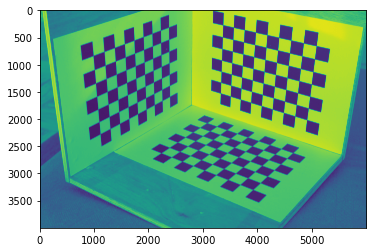

In [9]:
plt.imshow(gray)
print(gray.shape)

In [10]:
# Restrictions laissant un seul damier apparent

img1 = deepcopy(gray)
img1[:,IMG_WIDTH//2:] = 0

img2 = deepcopy(gray)
img2[:,:IMG_WIDTH//2] = 0

img3 = deepcopy(gray)
img3[:IMG_HEIGHT//3,:] = 0

sub_images = {
    "upper_left" : img1,
    "upper_right" : img2,
    "lower" : img3
}

In [11]:
# Calcul des points à l'infini

points_inf = {}
points_inf_hori = {}
points_inf_vert = {}
lines_inf = {}

for name,img in sub_images.items():
    
    # extract corners
    ret,corners = cv.findChessboardCorners(img, (9,7))
    corners = corners.reshape((7*9,2))
    
    if not(ret):
        raise Exception(f"Corners not found in image {name}")
    
    # compute linear regressions
    # horizontal lines
    lines_hori = []
    for i in range(7):
        data = corners[i*9:(i+1)*9,:]

        reglin = linregress(data[:,0],data[:,1])
        m,b = reglin.slope, reglin.intercept
        
        x0,x1 = data[0,0],data[-1,0]
        y0,y1 = b + x0*m, b+x1*m
        
        line = np.cross(
            np.array([x0,y0,1]), np.array([x1,y1,1])
        )
        
        lines_hori.append(line)
        
    # vertical lines
    lines_vert = []
    for i in range(9):
        data = corners[i::9,:]
        
        reglin = linregress(data[:,0],data[:,1])
        m,b = reglin.slope, reglin.intercept
        
        x0,x1 = data[0,0],data[-1,0]
        y0,y1 = b + x0*m, b+x1*m
        
        line = np.cross(
            np.array([x0,y0,1]), np.array([x1,y1,1])
        )
        
        lines_vert.append(line)
        
    # compute intersection points
    points_hori = np.zeros((21,3))

    k = 0 
    for i in range(7):
        for j in range(i+1,7):
            
            l1,l2 = lines_hori[i],lines_hori[j]
            points_hori[k,:] = np.cross(l1,l2)
            # points_hori[k,:] /= points_hori[k,2]
            k += 1

    points_vert = np.zeros((36,3))
    k = 0
    for i in range(9):
        for j in range(i+1,9):
            l1,l2 = lines_vert[i],lines_vert[j]
            points_vert[k,:] = np.cross(l1,l2)
            # points_vert[k,:] /= points_vert[k,2]
            k += 1
            
    # compute barycenters
    point_inf_hori = points_hori.mean(axis=0)
    point_inf_vert = points_vert.mean(axis=0)
    
    points_inf_hori[name] = point_inf_hori
    points_inf_vert[name] = point_inf_vert
    
    points_inf[name] = np.array([point_inf_hori, point_inf_vert])
    line_inf = np.cross(point_inf_hori,point_inf_vert)
    # line_inf /= line_inf[2]
    lines_inf[name] = line_inf

In [12]:
# Redressement image

point_inf = points_inf['upper_left']
line_inf = np.cross(point_inf[0,:],point_inf[1,:])
line_inf /= line_inf[2]

H = np.array([
    [1, 0, 0],
    [0, 1, 0],
    line_inf
])

# check bounds after transform
print(H@np.array([IMG_WIDTH,0,1]))
print(H@np.array([0,IMG_HEIGHT,1]))

img_redressed = cv.warpPerspective(gray, H, (IMG_WIDTH, IMG_HEIGHT) )

[6.00000000e+03 0.00000000e+00 3.60459169e-01]
[0.00000000e+00 4.00000000e+03 8.54734432e-01]


In [13]:
matplotlib.image.imsave('view1_redressed.png', img_redressed)

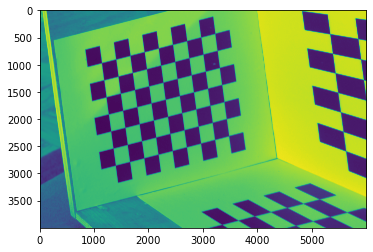

In [14]:
plt.imshow(img_redressed)

### Calibration caméra

In [24]:
# conctruction matrice A contraintes

points_inf_list = list(points_inf.values())
points_inf_hori_list = list(points_inf_hori.values())
points_inf_vert_list = list(points_inf_vert.values())
lines_inf_list = list(lines_inf.values())

# ((a,b),c) point n°a du plan b orthogonal au plan c
# a : 0 = hori (9) ; 1 = vert (7)
relations = [
    ((0,0),2),
    ((1,0),1),
    ((0,1),2),
    ((1,1),0),
    ((0,2),1),
    ((1,2),0),
]

j = 0

for i in range(2,7):
    for relations_comb in combinations(relations,i):       

        A = np.zeros((3*len(relations_comb),5))

        k = 0

        alreadyDone = []

        for rel in relations_comb:
            
            (vert_hori,plan_pt),plan_line = rel 
            
            line = lines_inf_list[plan_line]
            
            pt = points_inf_hori_list[plan_pt] if vert_hori == 0 else points_inf_vert_list[plan_pt]
            
            l1,l2,l3 = line
            v1,v2,v3 = pt

            A_ = np.array([
                [0, l2*v1, -l3*v2, l2*v2-l3*v3, l2*v3],
                [l3*v1, l2*v3-l1*v1, 0, -l1*v2, -l1*v3],
                [-l2*v1, -l2*v3, l1*v2, l1*v3, 0]
            ])

            A[k:k+3,:] = A_ 
                
            k += 3
            
        # SVD              
        U,S,Vh = svd(A)

        ω_ = Vh[-1,:]

        ω = np.array([
            [ω_[0], 0,     ω_[1]],
            [0,     ω_[2], ω_[3]],
            [ω_[1], ω_[3], ω_[4]]
        ]) 

        # Cholesky
        try :
            K = np.linalg.cholesky(np.linalg.inv(ω)).T
        except:
            continue
        
        print(f"I've found a working combination :{relations_comb}")
        

[-1.31099857e-10  1.18495195e-04 -1.74075769e-09  3.45304209e-05
 -9.99999992e-01]
[-7.00768220e-11  8.28943742e-07  1.22884061e-07  3.50548747e-04
  9.99999939e-01]
[-1.34802414e-10  1.19077946e-04 -1.84004756e-09  3.53968785e-05
 -9.99999992e-01]
[-2.40913913e-10 -2.96695401e-06  7.40132712e-08  2.72220297e-04
  9.99999963e-01]
[-8.20219526e-11  2.74650433e-19  1.18653520e-07  3.42899106e-04
  9.99999941e-01]
[ 2.25450694e-10 -1.26852633e-04 -3.48153152e-09  6.82176340e-05
 -9.99999990e-01]
[-4.04278238e-10 -1.73239414e-17  2.63675105e-09 -5.12723311e-05
  9.99999999e-01]
[ 8.94094364e-09 -4.52887513e-06 -3.96668313e-09  6.29816046e-05
 -9.99999998e-01]
[ 7.87644268e-08 -5.81970835e-04 -1.85592381e-08  2.31932735e-04
 -9.99999804e-01]
[ 2.29279201e-10 -1.27499127e-04 -3.57638933e-09  6.92531888e-05
 -9.99999989e-01]
[-1.44478642e-10  7.65506026e-19 -7.38384070e-08 -2.74920812e-04
 -9.99999962e-01]
[-5.50264142e-11  5.79863428e-07  1.19679495e-07  3.45964544e-04
  9.99999940e-01]
[-6.

In [16]:
K

array([[1.21625558e+02, 2.70184864e-04, 5.24386701e+01],
       [0.00000000e+00, 1.05729717e+00, 3.54234328e-02],
       [0.00000000e+00, 0.00000000e+00, 8.52587865e+01]])

In [22]:
# conctruction matrice A contraintes

points_inf_list = list(points_inf.values())
points_inf_hori_list = list(points_inf_hori.values())
points_inf_vert_list = list(points_inf_vert.values())
lines_inf_list = list(lines_inf.values())

# ((a,b),c) point n°a du plan b orthogonal au plan c
# a : 0 = hori (9) ; 1 = vert (7)
relations = [
    ((1,0),1),
    ((0,1),2),
]

relations = (((0, 0), 2), ((0, 1), 2))


A = np.zeros((3*len(relations_comb),5))

k = 0

alreadyDone = []

for rel in relations:
    
    (vert_hori,plan_pt),plan_line = rel 
    
    line = lines_inf_list[plan_line]
            
    pt = points_inf_hori_list[plan_pt] if vert_hori == 0 else points_inf_vert_list[plan_pt]
    
    l1,l2,l3 = line
    v1,v2,v3 = pt

    A_ = np.array([
        [0, l2*v1, -l3*v2, l2*v2-l3*v3, l2*v3],
        [l3*v1, l2*v3-l1*v1, 0, -l1*v2, -l1*v3],
        [-l2*v1, -l2*v3, l1*v2, l1*v3, 0]
    ])

    A[k:k+3,:] = A_ 
        
    k += 3
    
# SVD              
U,S,Vh = svd(A)

ω_ = Vh[-1,:]

ω = np.array([
    [ω_[0], 0,     ω_[1]],
    [0,     ω_[2], ω_[3]],
    [ω_[1], ω_[3], ω_[4]]
]) 

# Cholesky
K = np.linalg.cholesky(np.linalg.inv(ω)).T

print(K)

LinAlgError: Matrix is not positive definite

### Redresser image

In [13]:
K = np.array([
    [9.24884530e+03, 0.00000000e+00, 2.99965200e+03],
    [0.00000000e+00, 9.09644695e+03, 1.99981047e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

iK = np.linalg.inv(K)

In [39]:
idx = 0
line_inf = lines_inf_list[idx]

R = scipy.spatial.transform.Rotation.align_vectors(
    np.array([[0,0,1]]),np.array([K.T@line_inf])
)[0].as_matrix()

# check bounds after transform
print(K@R@iK@np.array([IMG_WIDTH,0,1]))
print(K@R@iK@np.array([0,IMG_HEIGHT,1]))

[-79.38768157   0.30754711 -85.43930298]
[-25.84329135  -0.37847411 -85.43105424]


/tmp/ipykernel_26832/1979149321.py:4: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  R = scipy.spatial.transform.Rotation.align_vectors(


In [78]:
t = np.array([
    [1, 0,  10000],
    [0, 1,  10000],
    [0, 0 , 1]
])

In [79]:
H = K@R@iK

# check bounds after transform
print(H@np.array([IMG_WIDTH,0,1]))
print(H@np.array([0,IMG_HEIGHT,1]))

xp = H@np.array([IMG_WIDTH,0,1])

H /= xp.max()

# check bounds after transform
print(H@np.array([IMG_WIDTH,0,1]))
print(H@np.array([0,IMG_HEIGHT,1]))


[-79.38768157   0.30754711 -85.43930298]
[-25.84329135  -0.37847411 -85.43105424]
[-258.13177326    1.         -277.80882811]
[ -84.03034943   -1.23062157 -277.78200704]


In [80]:
img_redressed = cv.warpPerspective(gray, t@H, (IMG_WIDTH*2, IMG_HEIGHT*2) )

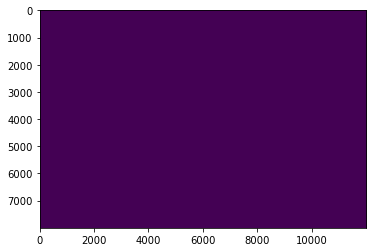

In [81]:
plt.imshow(img_redressed)

In [145]:
matplotlib.image.imsave('view1_redressed.png', img_redressed)

: 

: 